## Anomaly Detection- windowed method 

In [1]:
import numpy as np
import pickle
import pandas as pd
from datetime import datetime 
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from utils.functions import sample, create_sequences, get_error_term
from model.vae_window import vae_window

Importing the dataset

In [2]:
data = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv",
                   parse_dates=True, index_col="timestamp")

In [3]:
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances_of_anomaly= lists[0]

In [4]:
data_with_anomaly = data.copy()
data_with_anomaly['anomaly'] = 0
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data_with_anomaly.loc[(data_with_anomaly.index >= start) & (data_with_anomaly.index <= end), 'anomaly'] = 1

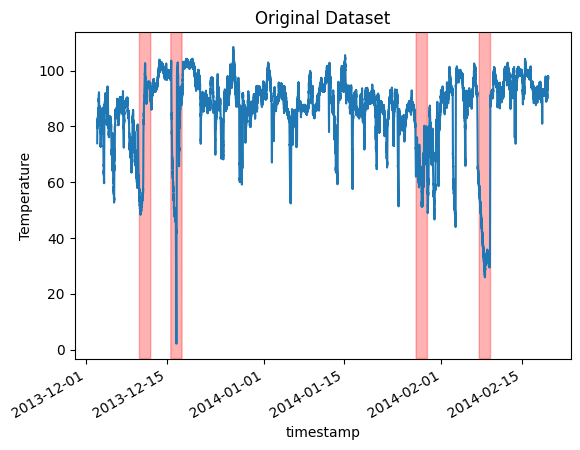

In [5]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
plt.ylabel("Temperature")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [6]:
# Splitting to train and test
test_ratio =0.2
start = int(len(data) * 0.25 )
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [7]:
tr_data

,value
timestamp,
2013-12-22 14:00:00,87.168898
2013-12-22 14:05:00,87.933798
2013-12-22 14:10:00,85.804768
2013-12-22 14:15:00,85.955663
2013-12-22 14:20:00,86.815269
...,...
2014-02-03 20:50:00,97.235514
2014-02-03 20:55:00,97.363425
2014-02-03 21:00:00,98.963034


Normailzing the training set 

In [8]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 12483


Function to create the windowed data

In [9]:
step_size = 288

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (12196, 288, 1)


VAE model

In [10]:
vae = vae_window(train, latent_dim=8)

In [11]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 144, 32)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 144, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 72, 16)    │      3,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     22,304 │ input_layer[0][0] │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 288, 1)    │     59,553 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 288, 1)    │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,857 (319.75 KB)

 Trainable params: 81,857 (319.75 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = vae.fit(
    train,
    train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/500
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1197.2358 - val_loss: 3691.3508
Epoch 2/500
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1052.1923 - val_loss: 4200.7935
Epoch 3/500
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1006.2128 - val_loss: 5163.4990
Epoch 4/500
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 939.7153 - val_loss: 6351.4312
Epoch 5/500
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 911.5135 - val_loss: 7435.3408
Epoch 6/500
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 854.5786 - val_loss: 7427.4053
Epoch 7/500
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 808.2379 - val_loss: 8047.1455
Epoch 8/500
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 796.1462 - val_loss: 8139.6025
Epoch 9/500
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 762.4562 - val_loss: 8833.5996


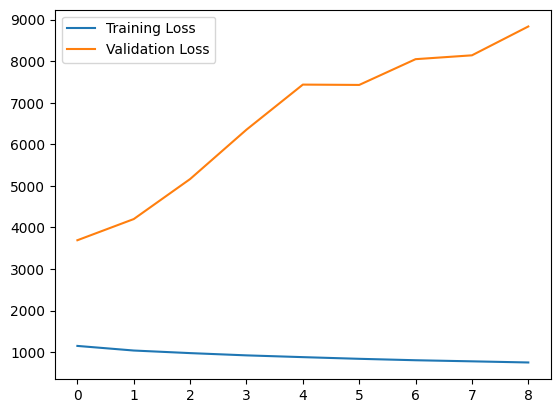

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(12196, 1)


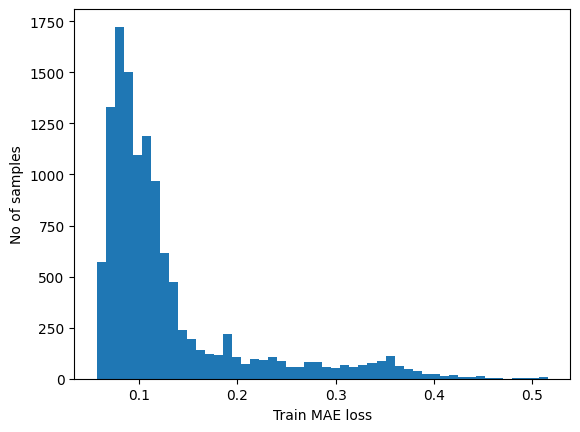

Reconstruction error threshold:  0.5156423384348903


In [30]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [31]:
print(train_pred.shape)

(12196, 288, 1)


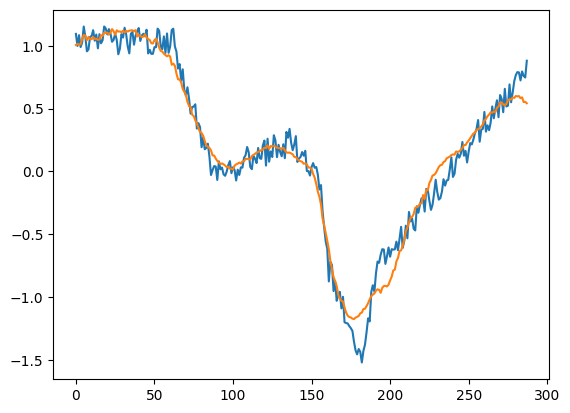

In [32]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

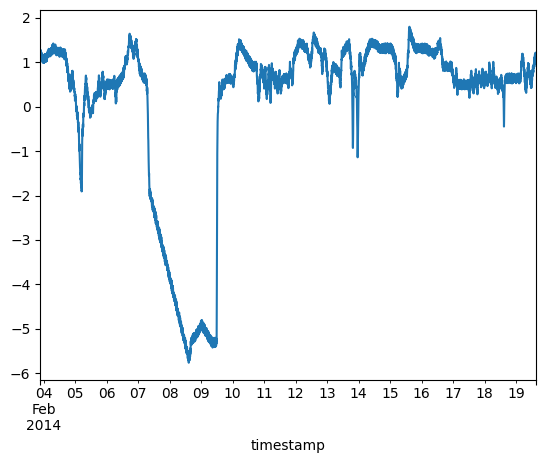

Test input shape:  (4252, 288, 1)
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(4252, 1)


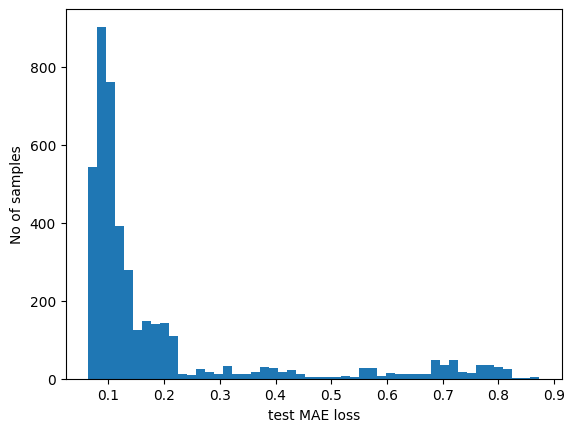

Number of anomaly samples:  436
Indices of anomaly samples:  (array([ 988,  989,  990,  991,  992,  993,  994,  995,  996,  997,  998,
        999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009,
       1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
       1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031,
       1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042,
       1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053,
       1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064,
       1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075,
       1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086,
       1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097,
       1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108,
       1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119,
       1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1

In [33]:
test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [39]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.sum(anomalies[data_idx - step_size + 1 : data_idx])> step_size * 0.9:
        anomalous_data_indices.append(data_idx)

In [40]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410

In [41]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-02-08 05:15:00,39.163552
2014-02-08 05:20:00,38.783130
2014-02-08 05:25:00,39.112686
2014-02-08 05:30:00,38.479101
2014-02-08 05:35:00,38.019513
...,...
2014-02-08 21:50:00,32.334426
2014-02-08 21:55:00,32.881380
2014-02-08 22:00:00,33.398893


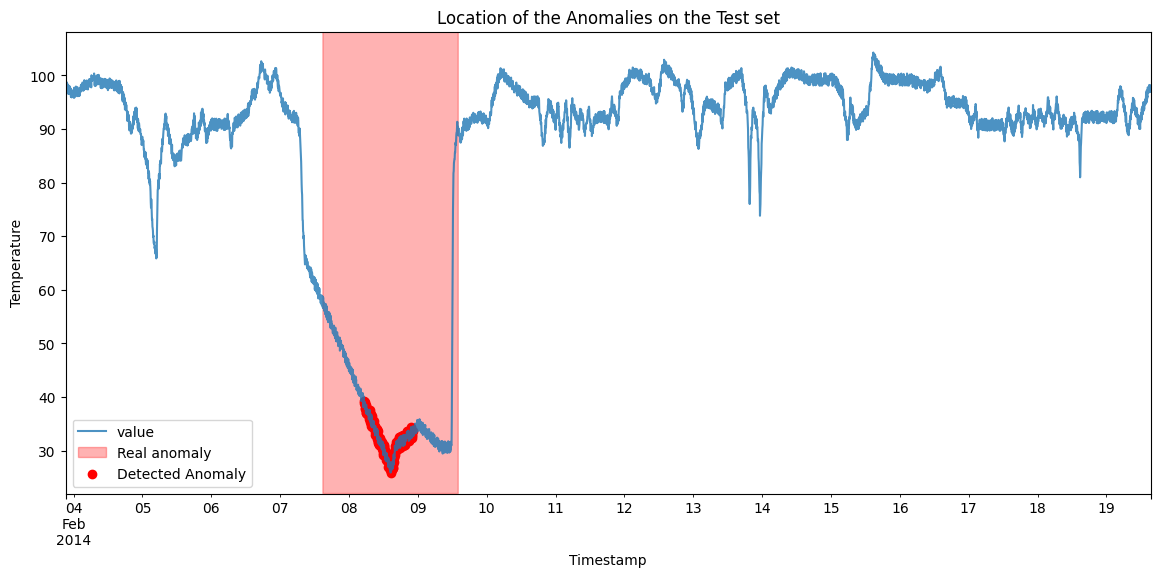

In [44]:
fig, ax = plt.subplots(figsize=(14, 6))
tst_data.plot(legend=False, ax=ax, alpha=0.8)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
ax.scatter(df_subset.index, df_subset['value'], color="r", label="Detected Anomaly")
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Location of the Anomalies on the Test set")
plt.show()

In [45]:
from utils.scoring import score_fn
anomaly_ranges = [(datetime.strptime(start, "%Y-%m-%d %H:%M:%S"), 
                       datetime.strptime(end, "%Y-%m-%d %H:%M:%S")) for start, end in instances_of_anomaly[3:]]
res = score_fn(list(df_subset.index), anomaly_ranges)
print (res)
print (f'Score: {np.sum(res)}')

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Score: 1
